In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
PATH_TO_FOLDER = "drive/MyDrive/Name2Demographics/"

In [3]:
%cd $PATH_TO_FOLDER

/content/drive/MyDrive/Name2Demographics


In [4]:
import pandas as pd
import numpy as np

In [5]:
import sys  

sys.path.insert(0, 'Models/AIEEEData/PreProcessing/')
from aieee_caste import *

In [6]:
caste_df = AIEEECasteData()

Models/AIEEEData/PreProcessing/aieee_caste.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[col] = [elem.replace("Sub-PH", "") for elem in df1[col]]


In [7]:
train_cx, train_cy, test_cx, test_cy = splitCaste(caste_df)

Train: ((175138, 30),(175138, 2))  Test: ((75065, 30),(75065, 2))


##Model

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM, Conv1D
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam

from sklearn.utils import class_weight
from sklearn.metrics import classification_report

In [11]:
voc = vocab()

In [12]:
input_ = Input(shape=(30,), name='input')
embed = Embedding(len(voc), len(voc), name='embed')(input_)
conv_1 = Conv1D(filters = 128, kernel_size = 7, activation = 'relu')(embed)
flat_2 = Flatten()(conv_1)
caste = Dense(2, activation='softmax', name='caste')(flat_2)
model = Model(inputs= input_, outputs=caste)

model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(learning_rate=1e-3),
  metrics={
      'caste':'binary_accuracy',
  },
  loss_weights=class_weight.compute_sample_weight('balanced',train_cy)
)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 30)]              0         
                                                                 
 embed (Embedding)           (None, 30, 28)            784       
                                                                 
 conv1d (Conv1D)             (None, 24, 128)           25216     
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 caste (Dense)               (None, 2)                 6146      
                                                                 
Total params: 32,146
Trainable params: 32,146
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.fit(
    {'input':train_cx},
    { 'caste':train_cy},
    validation_data= ({'input':test_cx},
    {'caste':test_cy}),
    batch_size=500,
    epochs=30,
)

Epoch 1/30
255/351 [====================>.........] - ETA: 4s - loss: 0.5267 - binary_accuracy: 0.7349

In [18]:
results = model.predict(test_cx)
y_pred = np.argmax(results, axis=1)
y_true = np.argmax(test_cy, axis=1)

target_names = ['GEN','RESERVED']

print("------------------RESULTS-------------------------------")
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))
print("--------------------------------------------------------")

------------------RESULTS-------------------------------
              precision    recall  f1-score   support

         GEN     0.7254    0.7785    0.7510     59343
    RESERVED     0.6938    0.6301    0.6604     47274

    accuracy                         0.7127    106617
   macro avg     0.7096    0.7043    0.7057    106617
weighted avg     0.7114    0.7127    0.7108    106617

--------------------------------------------------------


In [19]:
filename = "Models/AIEEEData/CNNModel/SavedModel/CasteModel"
model.save(filename)

INFO:tensorflow:Assets written to: Models/AIEEEData/CNNModel/SavedModel/CasteModel/assets


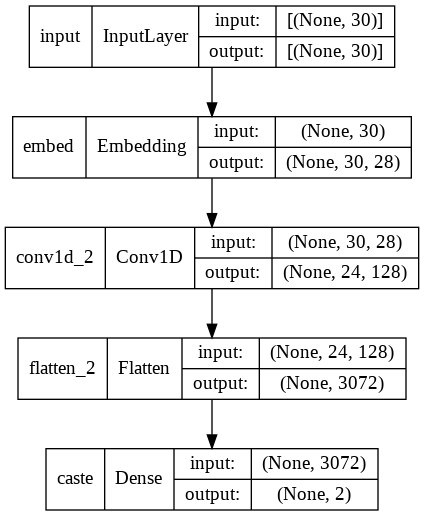

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True)

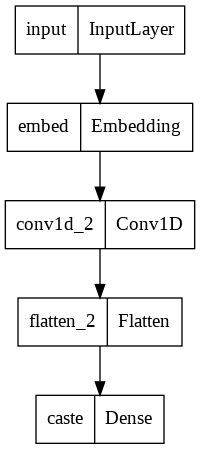

In [21]:
tf.keras.utils.plot_model(model)